In [1]:
%matplotlib inline

In [2]:
# General setup, execute this before running any other scripts
import sys
sys.path.append('..')

from tpFlow import *

# Setup output settings for notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
import components.flowUtils
components.flowUtils.ANNOTATE_PROGRESS = False

## Basics

We are using a few utility classes, most important of them is called `Flow`. This first section shows examples of its possible usages.

```Flow('Title', {'parameter name': 'parameter value'}, Component1, Component2, Component3)```
gives simmilar result as stacking components one into another
```Component3(Component2(Component1()))```
Hovewer there are some differences, this utility class allows you to do more. Each pipeline can be named using first parameter. Second parameter is used to pass paramters to components.

Flow also allows you to call methods from all the components. (Last added component containing method with given name is used)

Interfaces of different component types are described in `docs/interfaces.md`

### Default projection
Example of sourcecode to produce basic PCA projection. There is a few components used.
- *ProblemsUmime* - source of data
- *FilterProblems* - filtering problems to only one concept (vyjmenovana-slova-po-b), function used for filtering is given as parameter 'filterProblems'
- *PerformanceSimilarity* - this component computes similarity matrix from performance matrix using Pearson correlation ccoefficient
- *SimilarityMatrixPCAPlot* - this last component is used to create projection and display it

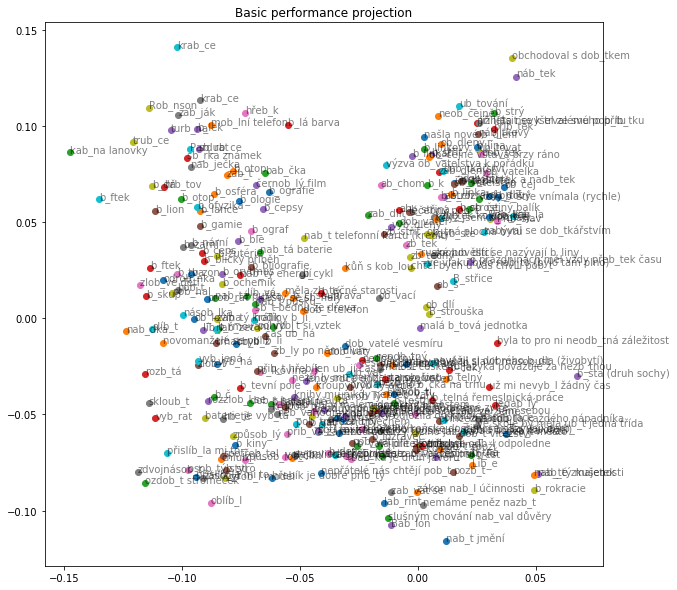

In [3]:
basicProjection = Flow('Basic performance projection', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b'])
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, SimilarityMatrixPCAPlot)
basicProjection.plot()

### Use t-SNE projection
Example of using different component

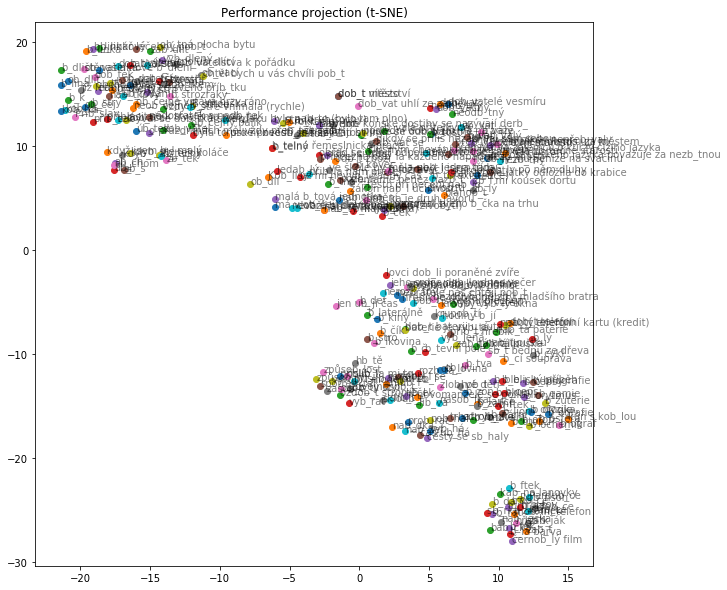

In [4]:
tsneProjection = Flow('Performance projection (t-SNE)', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b'])
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, SimilarityMatrixTSNEPlot)
tsneProjection.plot()

### Parameters


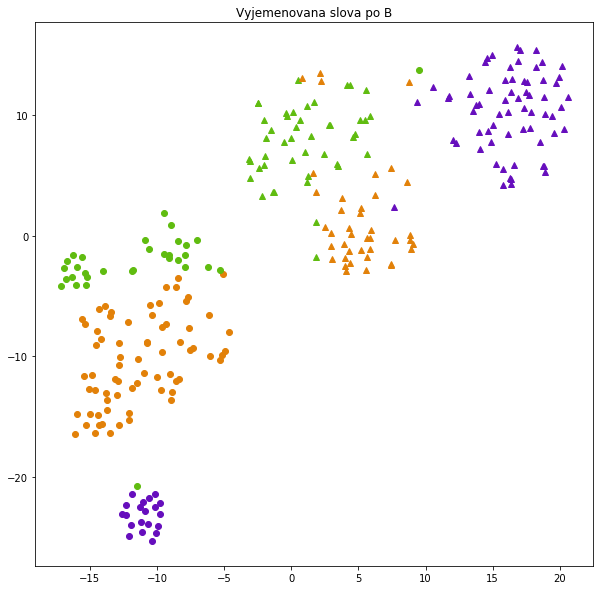

In [5]:
item_set = CONCEPTS["vyjmenovana-slova-po-b"]
cestinaNormalized = Flow('Vyjemenovana slova po B', {
    'filterProblems': filterProblemsByConcept(item_set),
    'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][item_set.index([x for x in item_set if x in problem['pss']][0])],
    'lambdaMarker': lambda problem: [MARKER_1, MARKER_2][0 if problem['solution'] in ['i', 'í'] else 1],
    'annotate': 0.0
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, LambdaProblemColor, LambdaProblemMarker, SimilarityMatrixTSNEPlot)
cestinaNormalized.plot()

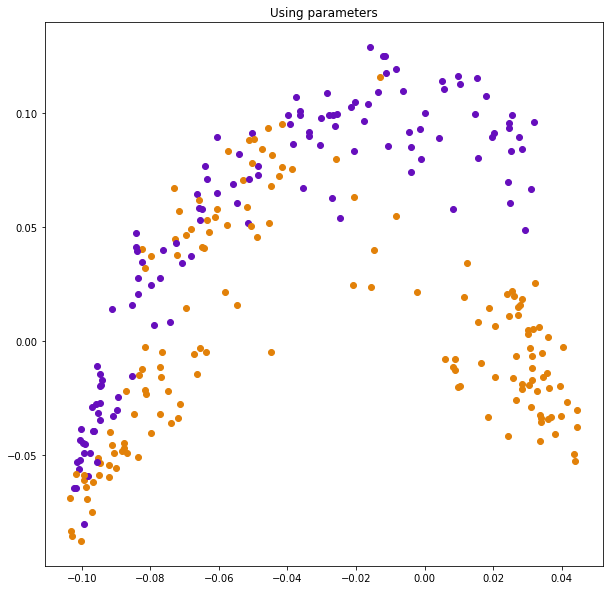

In [6]:
Flow('Using parameters', {
    'filterProblems': filterProblemsByConcept(CONCEPTS['vyjmenovana-slova-po-b']),
    'lambdaColor': lambda problem: COLOR_1 if problem['solution'] in ['i', 'í'] else COLOR_2,
    'similarityMetric': 'jaccard',
    'secondLevelOfCorrelation': True,
    'annotate': 0.0
}, ProblemsUmime, FilterProblems, BooleanPerformanceSimilarity, LambdaProblemColor, SimilarityMatrixPCAPlot).plot()

### Example of simulated data

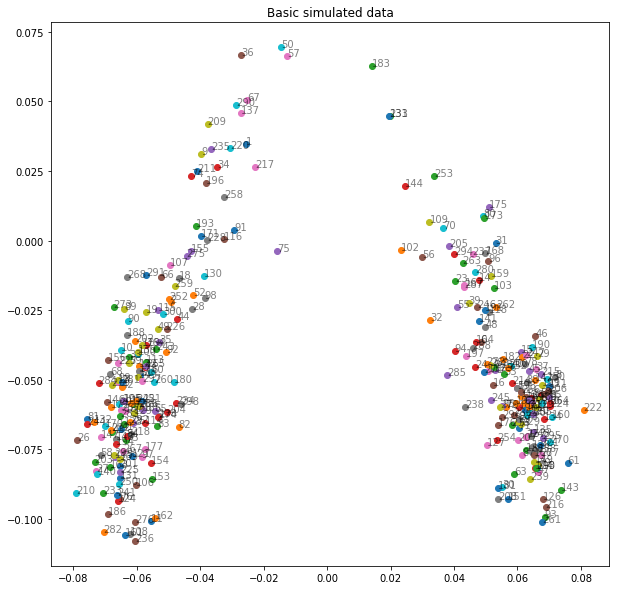

In [7]:
Flow("Basic simulated data", {
    'questionCount': 300,
    'questionDifficulty': [0.0],
    'questionSkill': [0.0, 0.0],
    'userCount': 3000
}, ProblemsSimulatedDefaultAnswer, PerformanceSimilarity, SimilarityMatrixPCAPlot).plot()

## Determinig what is affected by regularities

Following experiments are focusing on determining if regularities occur in all item-sets and used measures.

### Cluster quality analysis

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

clusterQuality = {}

for conceptTitle in sorted(CONCEPTS):
    conceptPss = CONCEPTS[conceptTitle]
    conceptPssCount = len(conceptPss)

    conceptFlow = Flow(conceptTitle, {
        'filterProblems': lambda problem: [x for x in conceptPss if x in problem['pss']]
    }, ProblemsUmime, FilterProblems, PerformanceSimilarity, SimilarityMatrixPCAPlot)

    problems = conceptFlow.getProblems()

    if conceptTitle.startswith("delka-"):
        transformSolution = lambda a: a
    else:
        transformSolution = unidecode

    answers = set([transformSolution(problem['solution']) for pid, problem in problems.items()])
    answers = sorted(list(answers))
    answersCount = len(answers)

    data = conceptFlow.getProjection()
    
    actual = np.array([ len(answers) * conceptPss.index([x for x in conceptPss if x in problem['pss']][0]) + answers.index(transformSolution(problem['solution'])) for pid, problem in problems.items() ])
    clustersCount = conceptPssCount * answersCount

    if clustersCount > 18:
        continue

    clusterQuality[conceptTitle] = [adjusted_rand_score(actual, KMeans(n_clusters=clustersCount, init='random', n_init=10).fit_predict(data)) for i in range(100)]

clusterQualityDf = pd.DataFrame(clusterQuality)
clusterQualitySummaryDf = clusterQualityDf.apply(lambda row: pd.Series([row.min(), row.median(), row.max()], ['min', 'median', 'max']))
clusterQualitySummaryDf = clusterQualitySummaryDf.transpose()
clusterQualitySummaryDf

,min,median,max
dalsi-zdvojene-souhlasky-dd-zz-kk-cc-jj,0.091739,0.131593,0.167218
delka-samohlasek-i,0.572914,0.572914,0.602962
delka-samohlasek-u,0.183117,0.221248,0.249602
jedno-versus-dve-pismena-c-ts-s-zs,0.083937,0.164687,0.260414
koncovky-mi-my-ma,0.264280,0.397985,0.486381
koncovky-ovi-ovy,1.000000,1.000000,1.000000
koncovky-podstatnych-jmen-muzsky-rod,0.482620,0.504954,0.648993
koncovky-podstatnych-jmen-stredni-rod,0.859304,0.859304,0.859304
koncovky-podstatnych-jmen-zensky-rod,0.410986,0.458734,0.466858
koncovky-pridavnych-jmen,0.478919,0.510414,0.525456


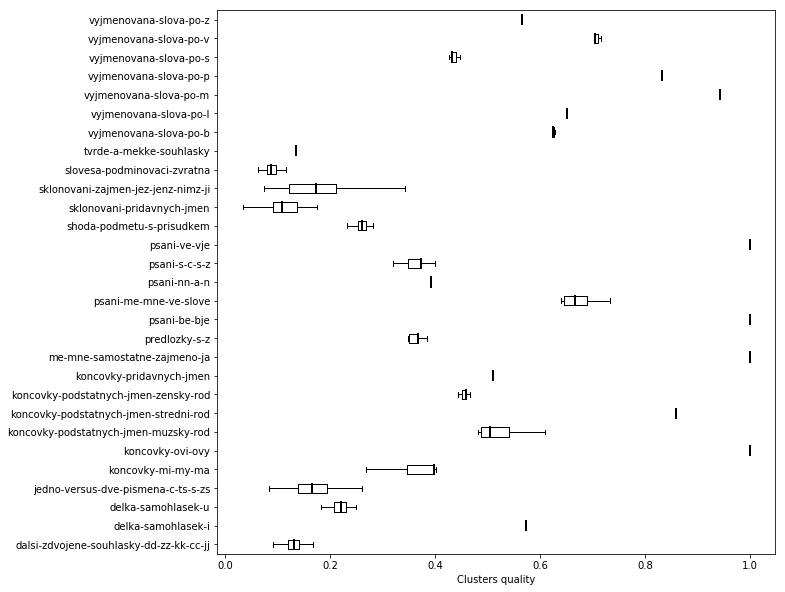

In [9]:
plt.rcParams['figure.figsize'] = (10, 10)

plt.figure()
plt.boxplot(clusterQualityDf.as_matrix(), labels=list(clusterQualityDf), showfliers=False, medianprops=dict(linestyle='-', linewidth=2.0, color='black'), vert=False)
# plt.xticks(rotation=90)
plt.xlabel("Clusters quality")
plt.show()

### Clustering is affected same as projection

In [10]:
from sklearn.cluster import KMeans

conceptPss = CONCEPTS["vyjmenovana-slova-po-b"]
conceptPssCount = len(conceptPss)

conceptFlow = Flow("Cestina data", {
    'filterProblems': lambda problem: [x for x in conceptPss if x in problem['pss']],
}, ProblemsUmime, FilterProblems, PerformanceSimilarity, SimilarityMatrixPCAPlot)

problems = conceptFlow.getProblems()

problemAnswers = [unidecode(problem['solution']) for pid, problem in problems.items()]
problemLevels = [[x for x in conceptPss if x in problem['pss']][0] for pid, problem in problems.items()]
answers = sorted(list(set(problemAnswers)))
answersCount = len(answers)

data = conceptFlow.getSimilarityMatrix()

clustersCount = 4 #conceptPssCount * answersCount

clustering = KMeans(n_clusters=clustersCount, init='random', n_init=1).fit_predict(data)

df = pd.DataFrame([list(problems.keys()), list(clustering), problemLevels, problemAnswers], index=["pid", "cluster", "level", "answer"]).transpose()

In [11]:
df.groupby("cluster")["level"].value_counts().unstack(level=0)

cluster,0,1,2,3
level,,,,
383,1.0,20.0,NaN,65.0
384,35.0,44.0,23.0,8.0
385,25.0,1.0,29.0,22.0


In [12]:
df.groupby("cluster")["answer"].value_counts().unstack(level=0)

cluster,0,1,2,3
answer,,,,
i,NaN,65.0,52.0,5.0
y,61.0,NaN,NaN,90.0


### Different similarity measures

Projections show same data using four different similairty measures.

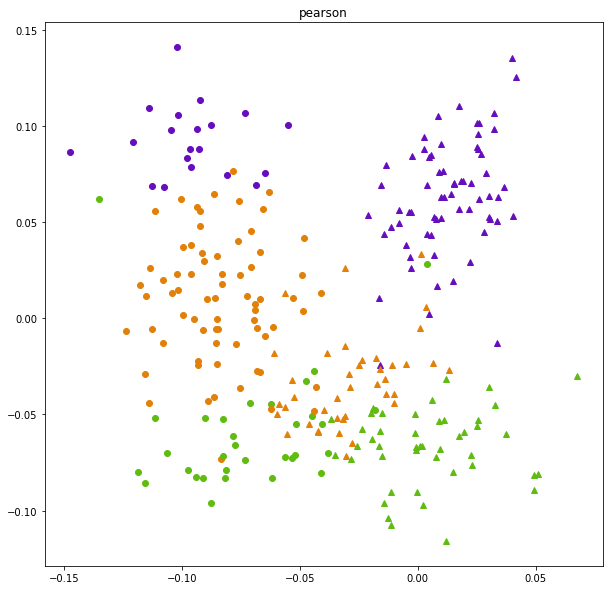

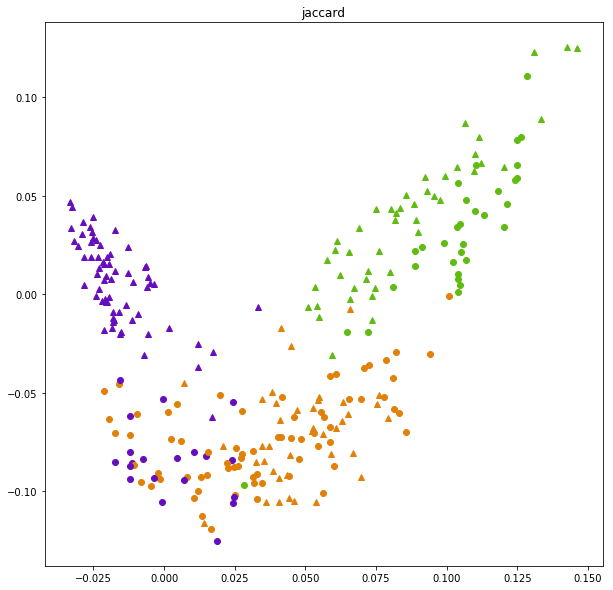

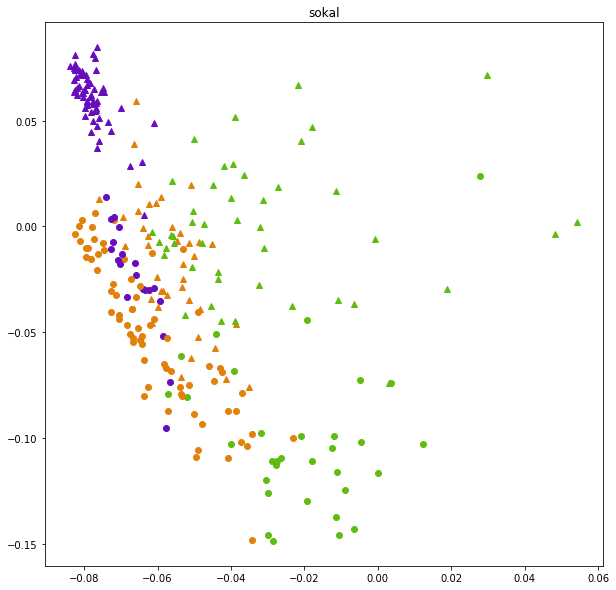

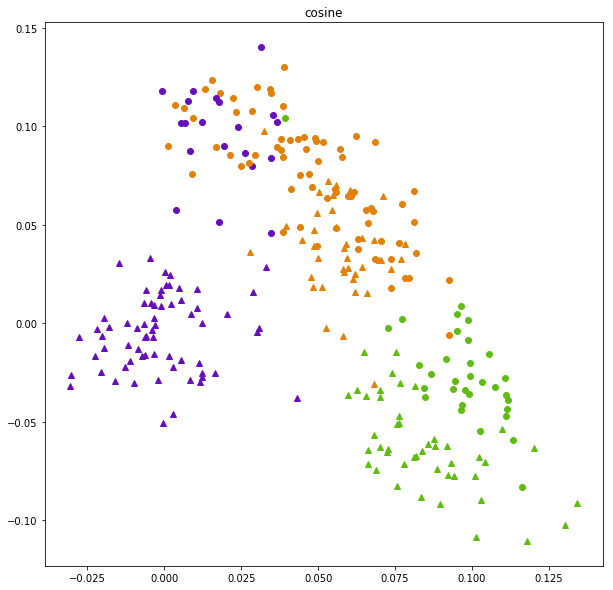

In [13]:
metrics = ['pearson', 'jaccard', 'sokal', 'cosine']
item_set = CONCEPTS['vyjmenovana-slova-po-b']
for metric in metrics:
    Flow(metric, {
        'filterProblems': filterProblemsByConcept(item_set),
        'lambdaColor': lambda problem: [COLOR_1, COLOR_2, COLOR_3][item_set.index([x for x in item_set if x in problem['pss']][0])],
        'lambdaMarker': lambda problem: [MARKER_1, MARKER_2][0 if problem['solution'] in ['i', 'í'] else 1],
        'similarityMetric': metric,
        'annotate': 0.0
    }, ProblemsUmime, FilterProblems, BooleanPerformanceSimilarity, LambdaProblemColor, LambdaProblemMarker, SimilarityMatrixPCAPlot).plot()